### Imputing year built

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as plt
import seaborn as sns
import sklearn
import math as m
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 
import os
import statsmodels.api as sm

In [2]:
datapath= 'C:/Users/vincentlee/Desktop/datascienceprojects/Kaggle/ashrae/'

building_df = pd.read_csv(datapath + 'building_metadata.csv')
weather_train = pd.read_csv(datapath + "weather_train.csv")
weather_test = pd.read_csv(datapath + "weather_test.csv")
train = pd.read_csv(datapath + "train.csv")
test = pd.read_csv(datapath + 'test.csv')



In [3]:
print("train:", train.shape)
print("test:",test.shape)
print("building:",building_df.shape)
print("weathertrain:",weather_train.shape)
print("weathertest:",weather_test.shape)

train: (20216100, 4)
test: (41697600, 4)
building: (1449, 6)
weathertrain: (139773, 9)
weathertest: (277243, 9)


In [4]:
print("train: ", train.columns)
print("test: " , test.columns)
print("weather train: ", weather_train.columns)
print("weather test: ", weather_test.columns)
print("building meta: ", building_df.columns)


train:  Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')
test:  Index(['row_id', 'building_id', 'meter', 'timestamp'], dtype='object')
weather train:  Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
weather test:  Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
building meta:  Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')


In [5]:
# function to check how many null values
def nullvalues(dataframe):
    data_dict = {}
    for col in dataframe.columns:
        data_dict[col] = round(dataframe[col].isnull().sum()/dataframe.shape[0]*100,2)
    DataFrame = pd.DataFrame.from_dict(data_dict, orient='index', columns=['%missing_values'])
    return(DataFrame)

In [6]:
nullvalues(building_df)

,%missing_values
site_id,0.00
building_id,0.00
primary_use,0.00
square_feet,0.00
year_built,53.42
floor_count,75.50


In [7]:
nullvalues(weather_train)

,%missing_values
site_id,0.00
timestamp,0.00
air_temperature,0.04
cloud_coverage,49.49
dew_temperature,0.08
precip_depth_1_hr,35.98
sea_level_pressure,7.60
wind_direction,4.48
wind_speed,0.22


In [8]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,7,799,Education,527431,1976.0,26.0
1,7,798,Education,409028,1970.0,21.0
2,7,802,Education,290625,1995.0,19.0
3,1,130,Lodging/residential,62893,1960.0,16.0
4,4,595,Education,270413,1971.0,14.0


In [9]:
building_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [10]:
site = building_df.groupby('site_id')

In [11]:
site.describe()

building_id                                                       \
              count    mean        std     min      25%     50%      75%   
site_id                                                                    
0             105.0    52.0  30.454885     0.0    26.00    52.0    78.00   
1              51.0   130.0  14.866069   105.0   117.50   130.0   142.50   
2             135.0   223.0  39.115214   156.0   189.50   223.0   256.50   
3             274.0   427.5  79.241193   291.0   359.25   427.5   495.75   
4              91.0   610.0  26.413380   565.0   587.50   610.0   632.50   
5              89.0   700.0  25.836021   656.0   678.00   700.0   722.00   
6              44.0   766.5  12.845233   745.0   755.75   766.5   777.25   
7              15.0   796.0   4.472136   789.0   792.50   796.0   799.50   
8              70.0   838.5  20.351085   804.0   821.25   838.5   855.75   
9             124.0   935.5  35.939764   874.0   904.75   935.5   966.25   
10             30.0  1012.5   8.803408   998.0  1005.25  1012.5  1019.75   
11              5.0  1030.0   1.581139  1028.0  1029.00  1030.0  1031.00   
12             36.0  1050.5  10.535654  1033.0  1041.75  1050.5  1059.25   
13            154.0  1145.5  44.600075  1069.0  1107.25  1145.5  1183.75   
14            102.0  1273.5  29.588849  1223.0  1248.25  1273.5  1298.75   
15            124.0  1386.5  35.939764  1325.0  1355.75  1386.5  1417.25   

                square_feet                 ... year_built          \
            max       count           mean  ...        75%     max   
site_id                                     ...                      
0         104.0       105.0   86394.638095  ...    2006.00  2016.0   
1         155.0        51.0   65002.392157  ...    1989.50  2007.0   
2         290.0       135.0   99542.214815  ...    1997.50  2014.0   
3         564.0       274.0   75290.383212  ...    2002.00  2017.0   
4         655.0        91.0   92876.241758  ...    1971.00  2016.0   
5         744.0        89.0   47612.415730  ...    1976.00  2013.0   
6         788.0        44.0   91857.704545  ...        NaN     NaN   
7         803.0        15.0  323634.533333  ...    1969.75  1995.0   
8         873.0        70.0   29712.200000  ...        NaN     NaN   
9         997.0       124.0  144874.209677  ...        NaN     NaN   
10       1027.0        30.0   71152.566667  ...        NaN     NaN   
11       1032.0         5.0  104563.400000  ...        NaN     NaN   
12       1068.0        36.0   79338.611111  ...        NaN     NaN   
13       1222.0       154.0  128342.090909  ...        NaN     NaN   
14       1324.0       102.0   95111.441176  ...        NaN     NaN   
15       1448.0       124.0   83921.387097  ...    1987.00  2014.0   

        floor_count                                                 
              count      mean       std  min  25%  50%   75%   max  
site_id                                                             
0               0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
1              51.0  7.000000  2.529822  2.0  5.5  7.0   8.0  16.0  
2               0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
3               0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
4              91.0  5.252747  2.702235  1.0  3.0  5.0   7.0  14.0  
5              89.0  2.280899  1.270189  1.0  1.0  2.0   3.0   8.0  
6               0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
7              15.0  8.733333  7.731814  1.0  3.0  6.0  12.0  26.0  
8              70.0  1.014286  0.119523  1.0  1.0  1.0   1.0   2.0  
9               0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
10             30.0  2.100000  1.184672  1.0  1.0  2.0   2.0   6.0  
11              0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
12              9.0  2.777778  1.301708  1.0  2.0  3.0   4.0   4.0  
13              0.0       NaN       NaN  NaN  NaN  NaN   NaN   NaN  
14              0.0       NaN       NaN  NaN  NaN  NaN   Na

### Filling in NA values for year

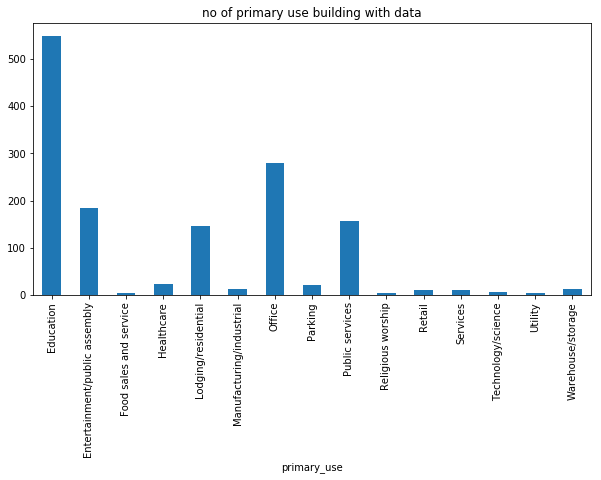

In [21]:
building_df.groupby(['primary_use']).size().plot(kind='bar',title='no of primary use building with data',
                                                figsize=(10,5))

In [14]:
building_df2 = building_df[~building_df['primary_use'].str.contains('Other',na=False)]
building_df2['primary_use'].str.contains('Other').sum()
round(building_df2['year_built'].groupby(building_df2['primary_use']).describe(),2)

,count,mean,std,min,25%,50%,75%,max
primary_use,,,,,,,,
Education,326.0,1962.58,31.84,1900.0,1935.75,1966.0,1986.0,2017.0
Entertainment/public assembly,73.0,1970.90,28.74,1900.0,1956.00,1976.0,1991.0,2016.0
Food sales and service,1.0,2012.00,NaN,2012.0,2012.00,2012.0,2012.0,2012.0
Healthcare,8.0,1982.25,37.25,1922.0,1958.00,2000.0,2010.5,2014.0
Lodging/residential,85.0,1973.28,30.85,1900.0,1953.00,1975.0,2002.0,2013.0
Manufacturing/industrial,6.0,1957.67,23.89,1919.0,1944.75,1969.0,1974.5,1976.0
Office,85.0,1972.89,28.40,1904.0,1960.00,1976.0,1994.0,2016.0
Parking,14.0,1998.50,14.52,1955.0,1997.25,2003.0,2007.0,2014.0
Public services,51.0,1964.33,30.38,1900.0,1945.00,1968.0,1981.0,2014.0


### Method 1
Fill NaN using test statistics from primary use

In [15]:
# change site_id and primary_use type to category data type
building_df2 = building_df2.copy()
building_df2['primary_use']= building_df2['primary_use'].astype('category')
building_df2['site_id']= building_df2['site_id'].astype('category')
building_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1424 non-null category
building_id    1424 non-null int64
primary_use    1424 non-null category
square_feet    1424 non-null int64
year_built     669 non-null float64
floor_count    342 non-null float64
dtypes: category(2), float64(2), int64(2)
memory usage: 59.9 KB


In [16]:
# convert each category value into a new column and assign a 1 or 0
building_df3 = building_df2.copy()
building_df3 = pd.get_dummies(building_df3, columns=['primary_use'],prefix=['primary_use'])
building_df3.head()

,site_id,building_id,square_feet,year_built,floor_count,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,7,799,527431,1976.0,26.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,798,409028,1970.0,21.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,802,290625,1995.0,19.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,130,62893,1960.0,16.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,595,270413,1971.0,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#fill in missing values with mean of square feet by primary use

building_education = building_df3[building_df3.primary_use_Education == 1]
building_education['year_built'] = building_education['year_built'].fillna(building_education.year_built.mean())

building_entertainment = building_df3[building_df3['primary_use_Entertainment/public assembly'] == 1]
building_entertainment['year_built'] = building_entertainment['year_built'].fillna(building_entertainment.year_built.mean())

building_food = building_df3[building_df3['primary_use_Food sales and service'] == 1]
building_food['year_built'] = building_food['year_built'].fillna(building_food.year_built.mean())

building_healthcare = building_df3[building_df3['primary_use_Healthcare'] == 1]
building_healthcare['year_built'] = building_healthcare['year_built'].fillna(building_healthcare.year_built.mean())

building_lodging = building_df3[building_df3['primary_use_Lodging/residential'] == 1]
building_lodging['year_built'] = building_lodging['year_built'].fillna(building_lodging.year_built.mean())

building_industrial = building_df3[building_df3['primary_use_Manufacturing/industrial'] == 1]
building_industrial['year_built'] = building_industrial['year_built'].fillna(building_industrial.year_built.mean())

building_office = building_df3[building_df3['primary_use_Office'] == 1]
building_office['year_built'] = building_office['year_built'].fillna(building_office.year_built.mean())

building_parking = building_df3[building_df3['primary_use_Parking'] == 1]
building_parking['year_built'] = building_parking['year_built'].fillna(building_parking.year_built.mean())

building_public = building_df3[building_df3['primary_use_Public services'] == 1]
building_public['year_built'] = building_public['year_built'].fillna(building_public.year_built.mean())

building_religious = building_df3[building_df3['primary_use_Religious worship'] == 1]
building_religious['year_built'] = building_religious['year_built'].fillna(building_religious.year_built.mean())

building_retail = building_df3[building_df3['primary_use_Retail'] == 1]
building_retail['year_built'] = building_retail['year_built'].fillna(building_retail.year_built.mean())

building_services = building_df3[building_df3['primary_use_Services'] == 1]
building_services['year_built'] = building_services['year_built'].fillna(building_services.year_built.mean())

building_tech = building_df3[building_df3['primary_use_Technology/science'] == 1]
building_tech['year_built'] = building_tech['year_built'].fillna(building_tech.year_built.mean())

building_utility = building_df3[building_df3['primary_use_Utility'] == 1]
building_utility['year_built'] = building_utility['year_built'].fillna(building_tech.year_built.mean())

building_warehouse = building_df3[building_df3['primary_use_Warehouse/storage'] == 1]
building_warehouse['year_built'] = building_warehouse['year_built'].fillna(building_warehouse.year_built.mean())

C:\Users\vincentlee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\vincentlee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\vincentlee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [23]:
building_food

,site_id,building_id,square_feet,year_built,floor_count,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
483,2,179,24867,2012.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
585,2,281,28862,2012.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1105,13,1105,33215,2012.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1247,14,1247,69876,2012.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1265,14,1265,35605,2012.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
